In [1]:
%load_ext autoreload 
%autoreload 2 

In [2]:
import random
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec # for subplots
import pandas as pd
import numpy as np
import seaborn as sns
import seaborn.objects as so
import tensorflow as tf

from src.utilities.plot_helpers import generate_random_colors
from src.modeling.experiments.binned_trial_experiment_01 import split_data

from src.utilities.pandas_helpers import get_features
plt.rcdefaults()

2023-07-19 14:27:39.910956: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-19 14:27:39.997791: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-19 14:27:44.812056: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Experimental conditions: 
* 2 layer LSTM 
* trained with 128 units
* control data is full dataset
* experimental data is full dataset without binned trials

#### Load Model

In [3]:
# directory paths
DATA_PATH = '/projects/p31961/gaby_data/aggregated_data/data_pipeline_full_dataset/datasets/full_dataset.parquet.gzip'
PATH_TO_MODELS = '/projects/p31961/ENIGMA/results/experiments/binned_trial_experiment_01/models'
control_path = os.path.join(PATH_TO_MODELS, 'control')
no_bins_path = os.path.join(PATH_TO_MODELS, 'dropped_binned_trials')


In [19]:

control_model = tf.keras.models.load_model(control_path)
# dropped_bins_model = tf.keras.models.load_model(no_bins_path)
control_model.compile(optimizer='adam', loss='mse', metrics=[
                  'mae', 'mse', 'mape', 'cosine_similarity'])
# dropped_bins_model.compile(optimizer='adam', loss='mse', metrics=[
#                   'mae', 'mse', 'mape', 'cosine_similarity'])


# models = [control_model, dropped_bins_model]

2023-07-19 14:35:04.721865: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_2_grad_concat_split_2_split_dim' with dtype int32
	 [[{{node gradients_split_2_grad_concat_split_2_split_dim}}]]
2023-07-19 14:35:04.721974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_grad_concat_split_split_dim' with dtype int32
	 [[{{node gradients_split_grad_concat_split_split_dim}}]]
2023-07-19 14:35:04.722047: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

# Model Summary

In [ ]:
for model in models:
    print(model.summary())

#### load training and testing data

In [50]:
data= pd.read_parquet(DATA_PATH)
mouse_id_encoder = pd.get_dummies(data['mouse_id'])
mouse_id_encoder

time  mouse_id  sex_M  day  trial  trial_count  learning_phase  \
0       -25.000000        12      0    5      0          115               0   
1       -24.901531        12      0    5      0          115               0   
2       -24.803064        12      0    5      0          115               0   
3       -24.704596        12      0    5      0          115               0   
4       -24.606127        12      0    5      0          115               0   
...            ...       ...    ...  ...    ...          ...             ...   
5858795  19.606127         1      0    4      1           87               0   
5858796  19.704596         1      0    4      1           87               0   
5858797  19.803064         1      0    4      1           87               0   
5858798  19.901531         1      0    4      1           87               0   
5858799  20.000000         1      0    4      1           87               0   

         event_cue  event_escape  event_avoid  latency  event_shock  \
0                1             0            0     0.00            0   
1                1             0            0     0.00            0   
2                1             0            0     0.00            0   
3                1             0            0     0.00            0   
4                1             0            0     0.00            0   
...            ...           ...          ...      ...          ...   
5858795          0             1            0     7.54            0   
5858796          0             1            0     7.54            0   
5858797          0             1            0     7.54            0   
5858798          0             1            0     7.54            0   
5858799          0             1            0     7.54            0   

         sensor_D1  sensor_D2  sensor_DA    signal  
0                0          1          0 -0.155359  
1                0          1          0 -0.420553  
2                0          1          0 -1.592294  
3                0          1          0 -1.268734  
4                0          1          0 -0.210176  
...            ...        ...        ...       ...  
5858795          1          0          0  0.299603  
5858796          1          0          0 -0.249408  
5858797          1          0          0 -0.486369  
5858798          1          0          0 -0.146374  
5858799          1          0          0  0.068169  

[5858800 rows x 16 columns]

In [ ]:
mouse_id_encoder.drop(columns = "mouse_id").to_parquet('/projects/p31961/gaby_data/aggregated_data/data_pipeline_full_dataset/datasets/full_dataset.parquet.gzip')

In [49]:
# split data for control
target='signal'
control_features = get_features(data, target)
no_bin_features = control_features.copy()
no_bin_features.remove('learning_phase')

X_train, y_train, X_val, y_val, X_test, y_test = split_data(data, control_features, target, day_cut_off=6, feature_to_drop=None)

    # split data for dropped binned trials
X_train_dropped, y_train_dropped, X_val_dropped, y_val_dropped, X_test_dropped, y_test_dropped = split_data(
data, no_bin_features, target, day_cut_off=6, feature_to_drop='learning_phase')

### predict signal for train set to plot (overfit check)

In [29]:
train_inference_y = control_model.predict(X_train)

133512/133512 [==============================] - 241s 2ms/step


## predict signal for test set

In [ ]:
y_control_pred = control_model.predict(X_test)
# y_dropped_pred = dropped_bins_model.predict(X_test_dropped)

## Validation check

In [8]:
data_directory = os.path.dirname(DATA_PATH)

### control dataset with inference

In [ ]:
control_inference_data= X_test.assign(predicted_signal= y_control_pred,
                                              true_signal=y_test)
control_inference_data.to_parquet(os.path.join(data_directory, 'control_inference_data.parquet.gzip'), compression='gzip')

## Control dataset with inference training data

In [31]:
train_inference_data = X_train.assign(predicted_signal= train_inference_y,
                                              true_signal=y_train)

In [6]:
#load data if previously saved
control_inference_data = pd.read_parquet(os.path.join(data_directory, 'control_inference_data.parquet.gzip'))


In [46]:
data

time  mouse_id  sex_M  day  trial  learning_phase  event_cue  \
0       -25.000000        12      0    5      0               0          1   
1       -24.901531        12      0    5      0               0          1   
2       -24.803064        12      0    5      0               0          1   
3       -24.704596        12      0    5      0               0          1   
4       -24.606127        12      0    5      0               0          1   
...            ...       ...    ...  ...    ...             ...        ...   
5858795  19.606127         1      0    4      1               0          0   
5858796  19.704596         1      0    4      1               0          0   
5858797  19.803064         1      0    4      1               0          0   
5858798  19.901531         1      0    4      1               0          0   
5858799  20.000000         1      0    4      1               0          0   

         event_escape  event_avoid  latency  event_shock  sensor_D1  \
0                   0            0     0.00            0          0   
1                   0            0     0.00            0          0   
2                   0            0     0.00            0          0   
3                   0            0     0.00            0          0   
4                   0            0     0.00            0          0   
...               ...          ...      ...          ...        ...   
5858795             1            0     7.54            0          1   
5858796             1            0     7.54            0          1   
5858797             1            0     7.54            0          1   
5858798             1            0     7.54            0          1   
5858799             1            0     7.54            0          1   

         sensor_D2  sensor_DA    signal  
0                1          0 -0.155359  
1                1          0 -0.420553  
2                1          0 -1.592294  
3                1          0 -1.268734  
4                1          0 -0.210176  
...            ...        ...       ...  
5858795          0          0  0.299603  
5858796          0          0 -0.249408  
5858797          0          0 -0.486369  
5858798          0          0 -0.146374  
5858799          0          0  0.068169  

[5858800 rows x 15 columns]

In [ ]:
# interm_path = '/Users/michaelschaid/Desktop/interm_data_transfer/control_inference_data.parquet.gzip'
# control_inference_data = pd.read_parquet(interm_path)

In [34]:
events = ['event_cue','event_avoid', 'event_escape', 'event_shock']
sensors = ['sensor_D1', 'sensor_D2', 'sensor_DA']

def format_for_plotting(df):
        cols_to_merge = ['true_signal', 'predicted_signal']
        cols = ['time',
                'mouse_id',
                'day',
                'trial',
                'learning_phase',
                'latency',
                'event',
                'sensor',
                'male']
        return (
        df
        .assign(event = lambda df_:df_[events].idxmax(axis=1).str.replace('event_', '').astype('category'),
                sensor = lambda df_: df_[sensors].idxmax(axis=1).str.replace('sensor_', '').astype('category'), 
                male = lambda df_: df_.sex_M.astype(bool)
                )
        .drop(columns=events+sensors + ['sex_M'])
        .melt(id_vars=cols, 
              value_vars=cols_to_merge, 
              var_name='signal_type', 
              value_name='signal')
        .assign(signal_type = lambda df_: df_.signal_type.str.replace('_signal', '').astype('category'))
        )
    
# con_data= format_for_plotting(control_inference_data)
# con_data.head()
train_data = format_for_plotting(train_inference_data)
train_data.head()


time  mouse_id  day  trial  learning_phase  latency event sensor  \
0 -25.000000        12    5      0               0      0.0   cue     D2   
1 -24.901531        12    5      0               0      0.0   cue     D2   
2 -24.803064        12    5      0               0      0.0   cue     D2   
3 -24.704596        12    5      0               0      0.0   cue     D2   
4 -24.606127        12    5      0               0      0.0   cue     D2   

    male signal_type    signal  
0  False        true -0.155359  
1  False        true -0.420553  
2  False        true -1.592294  
3  False        true -1.268734  
4  False        true -0.210176

In [35]:
# function to plot data for a given query of sex and sensor
def generate_plot(df, query, sensor, sex):
    palette = ['cornflowerblue', 'forestgreen', 'lightsalmon']
    facet_kwags = {
        'row':'event', 
        'row_order': ['cue', 'avoid', 'escape', 'shock'],
        'col': 'signal_type',
        'col_order': ['true', 'predicted'],
        'hue':'learning_phase',
        'palette':palette,
        'sharex':True,
        'sharey':True,
        'margin_titles':True
    }
    plot_kwags = {
        'x':'time',
        'y':'signal',
        'linewidth':0.5, 
    }

    
    set_kwar = {
        'xlabel':{'label': 'Time (s)', 'fontsize': 16},
        'ylabel':{'label': 'Signal','fontsize': 16}
    }
    
    title = f'{sex} | {sensor}'
    grid = (sns
            .FacetGrid(df.query(query), **facet_kwags)
            .map_dataframe(sns.lineplot, **plot_kwags)
            .set_titles(row_template = '{row_name}', col_template = '{col_name}', size=16)
            # .set(**set_kwar)
            .add_legend(title = 'Learning Phase', bbox_to_anchor=(1.2, 0.5), loc='center right')
    )
    for ax in grid.axes.flat:
        ax.tick_params(labelsize=12) 
        ax.set_xlabel('Time (s)', fontsize=16) 
        ax.set_ylabel('Signal', fontsize=16)
    
    grid.fig.suptitle(title, fontsize=24)
    plt.tight_layout()
    plt.show()
    return grid
# test_df = con_data[::500]
# female_DA = "sensor == 'DA' & male == False"
# female_DA_plot = generate_plot(test_df, female_DA, sensor='DA', sex='female')

In [36]:
def plot_trial_query(df, query):
    df = df.query(query)
    return  (
    so
    .Plot(df, x = 'time',  y = 'signal', color = 'signal_type')
    .add(so.Line(), so.Agg(), group = 'signal_type', group_order = ['true', 'predicted'])
    .add(so.Band(), so.Agg(), group = 'signal_type')
    .facet(row = 'event', col = 'trial')
    .share(x = True, y = True)
    .scale(color = ['black', 'red'])
    .layout(size = (35, 15))
    

)

In [37]:
def plot_trial_query(df, query):
    palette = ['black','red']
    facet_kwags = {
        'row':'event', 
        'row_order': ['cue', 'avoid', 'escape', 'shock'],
        'col': 'trial',
        'hue':'signal_type',
        'hue_order': ['true', 'predicted'],
        'palette':palette,
        'sharex':True,
        'sharey':True,
        'margin_titles':True, 
        'height': 10,
    }
    plot_kwags = {
        'x':'time',
        'y':'signal',
        'linewidth':1, 
    }

    
    set_kwar = {
        'xlabel':{'label': 'Time (s)', 'fontsize': 16},
        'ylabel':{'label': 'Signal','fontsize': 16}
    }
    
    grid = (sns
            .FacetGrid(df.query(query), **facet_kwags)
            .map_dataframe(sns.lineplot, **plot_kwags)
            .set_titles(row_template = '{row_name}', col_template = '{col_name}', size=16)
            # .set(**set_kwar)
            .add_legend(title = 'Signal Type', loc='center right')
    )
    for ax in grid.axes.flat:
        ax.tick_params(labelsize=12) 
        ax.set_xlabel('Time (s)', fontsize=16) 
        ax.set_ylabel('Signal', fontsize=16)
    
    # grid.fig.suptitle(title, fontsize=24)
    plt.tight_layout()
    plt.show()
    return grid

In [ ]:
query = "mouse_id == 1 & sensor == 'DA' & trial <5"
plot_trial_query(con_data, query)

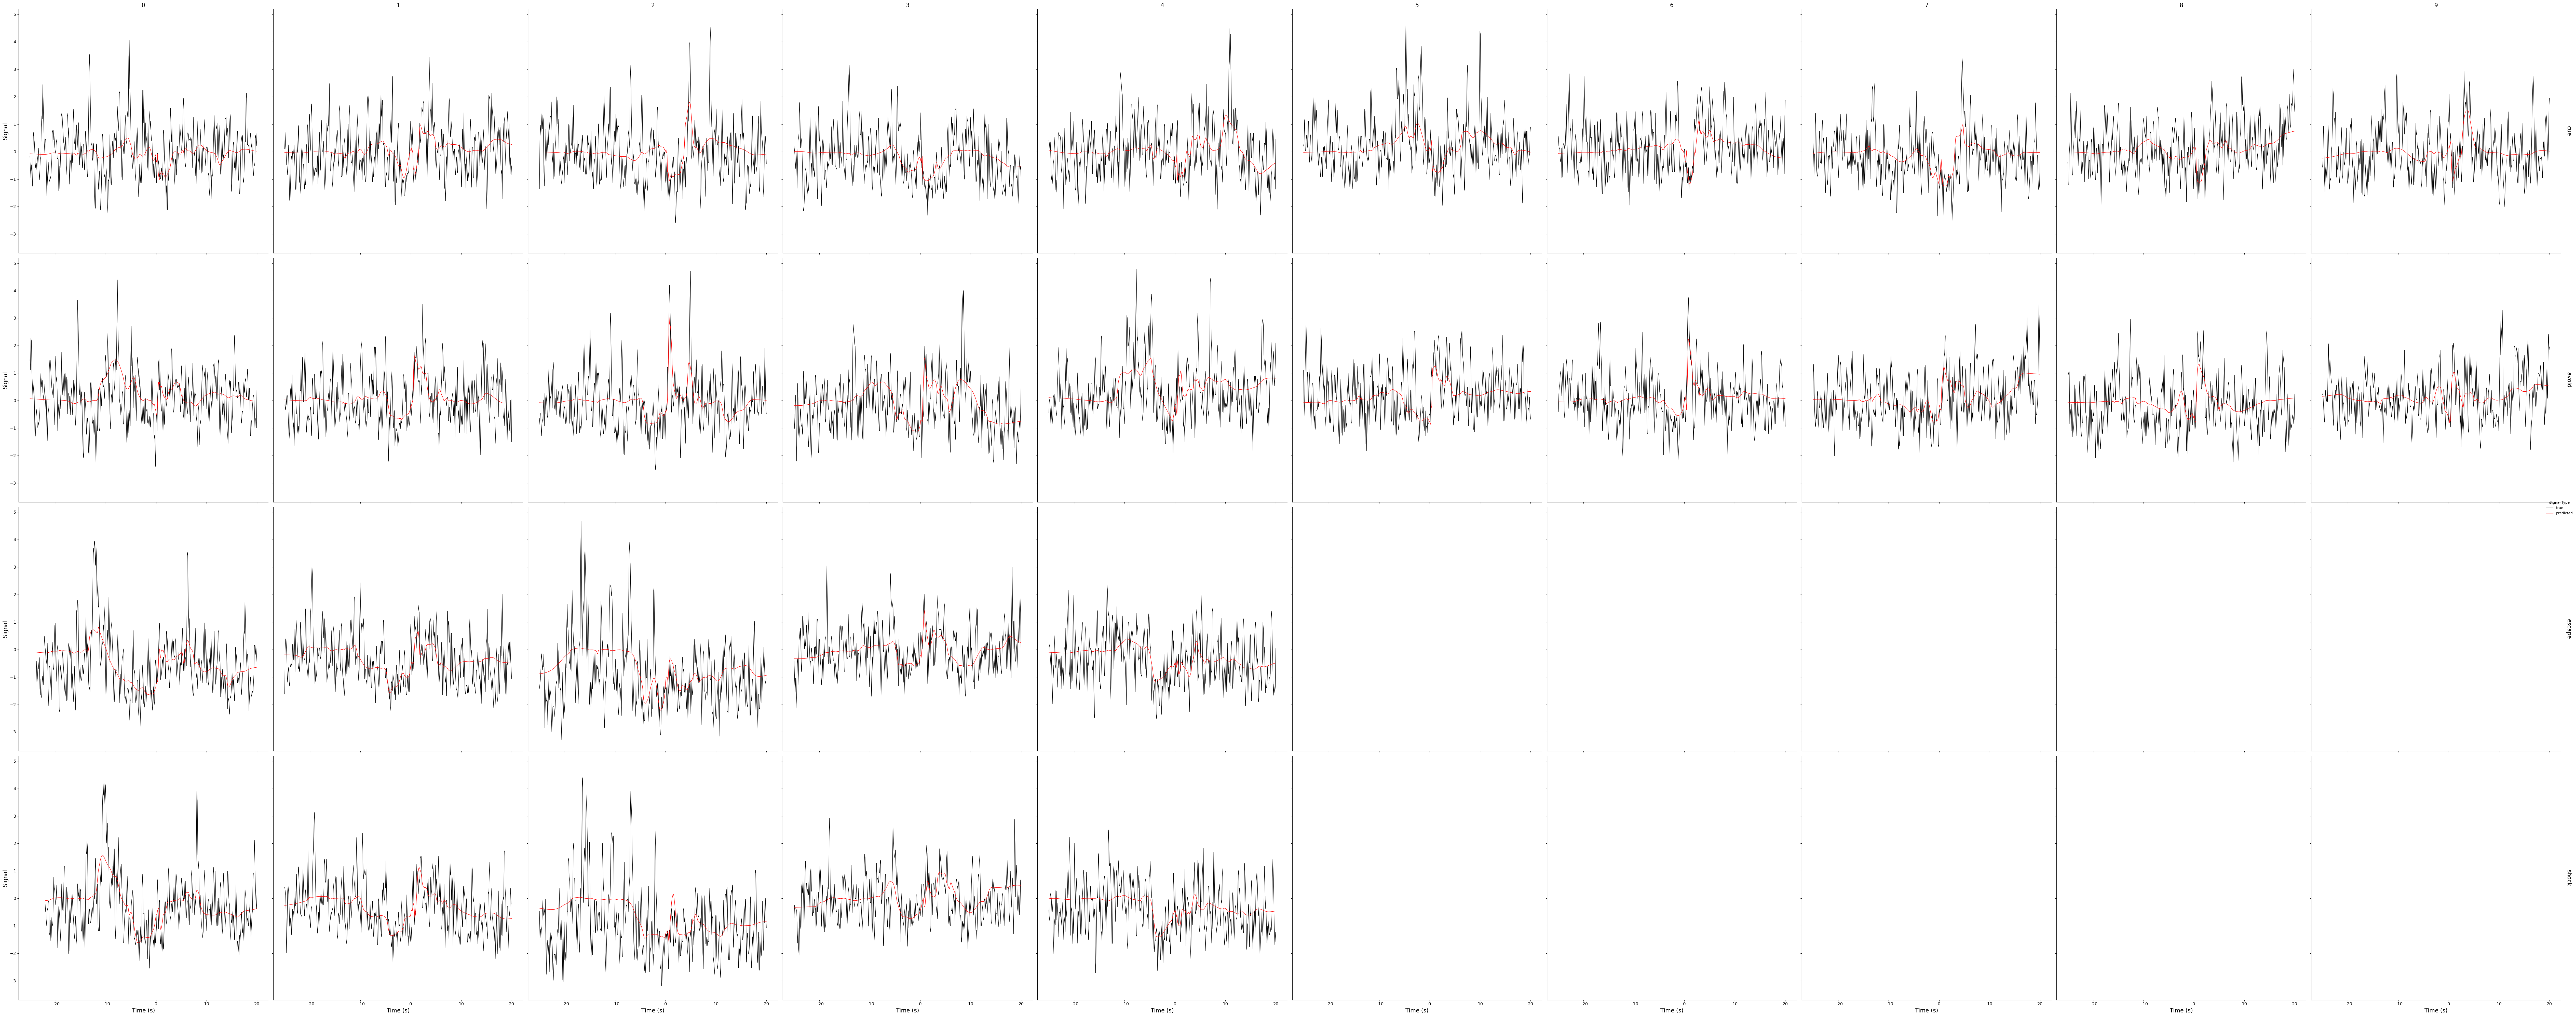

In [40]:
### trials for training data day 3
query = "mouse_id == 1 & day ==3 & sensor == 'DA' & trial <10"
plot_trial_query(train_data, query)

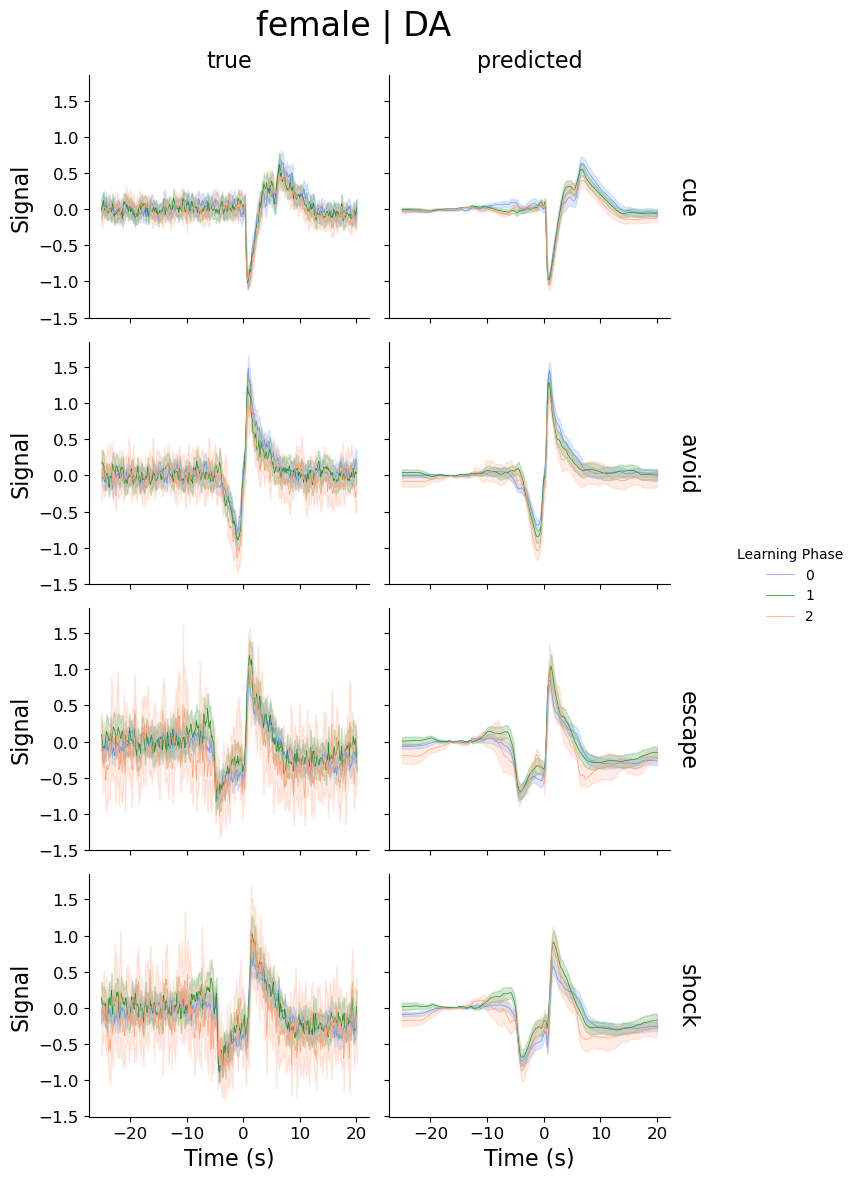

In [41]:
    
female_DA = "sensor == 'DA' & male == False"
female_DA_plot = generate_plot(train_data, female_DA, sensor='DA', sex='female')

### Male

In [ ]:
male_DA = "sensor == 'DA' & male == True"
male_DA_plot = generate_plot(con_data, male_DA, sensor='DA', sex='male')

## D1 (GCaMP)

### Female

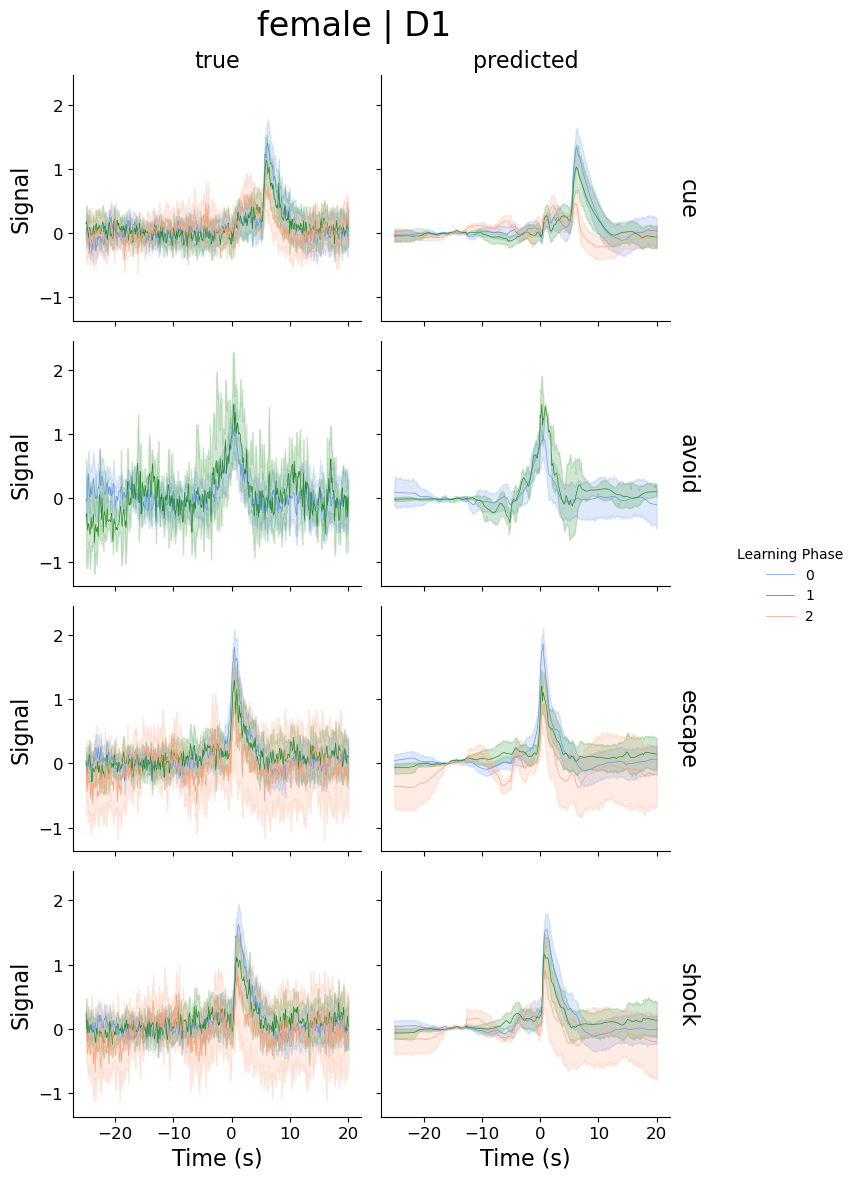

In [43]:
female_D1 = "sensor == 'D1' & day==1 & male == False"  
female_D1_plot = generate_plot(train_data, female_D1, sensor = 'D1', sex = 'female')

### Male

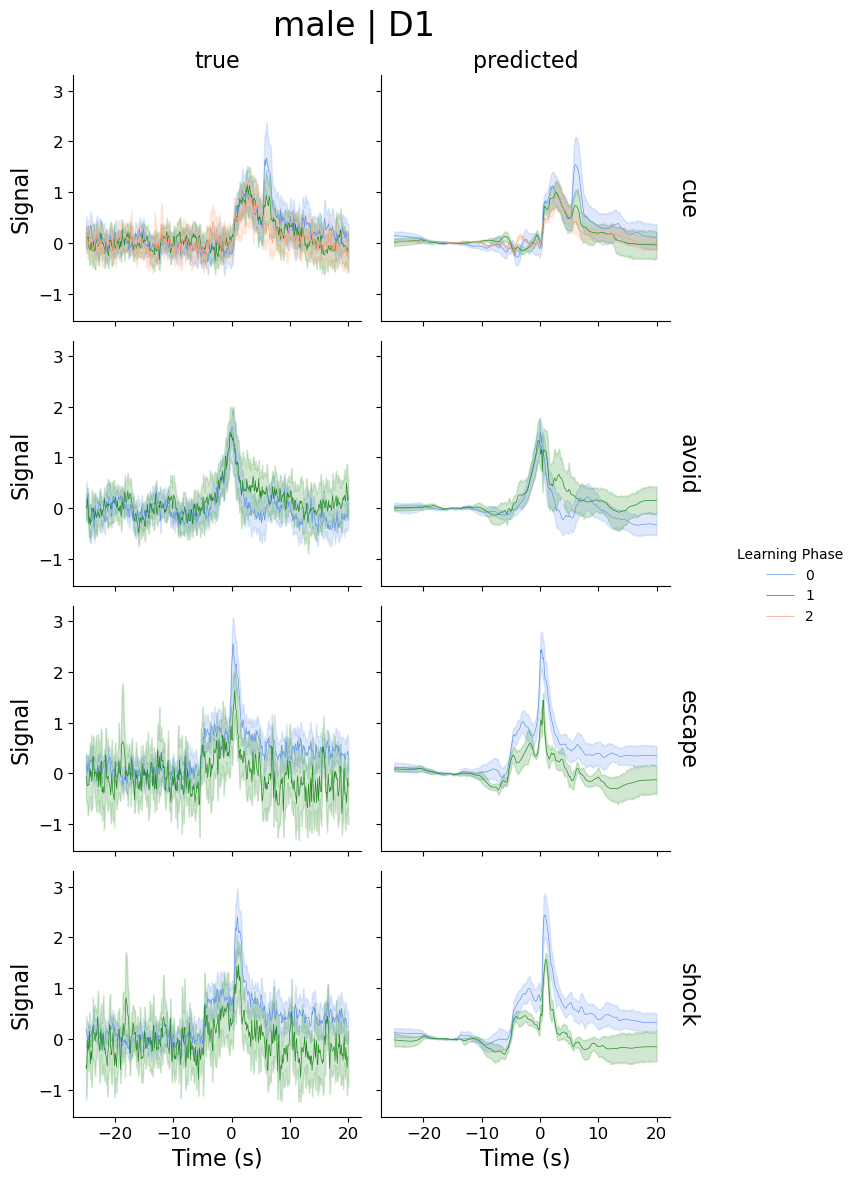

In [45]:

male_D1 =  "sensor == 'D1' & day==2 & male == True"  
male_D1_plot = generate_plot(train_data, male_D1, sensor = 'D1', sex = 'male')

## D2(GCaMP)

### Female

In [ ]:
female_D2 = "sensor == 'D2' & male == False"
female_D2_plot = generate_plot(con_data, female_D2, sensor = 'D2', sex = 'female')

### Male

In [ ]:
male_D2 = "sensor == 'D2' & male == True"
male_D2_plot = generate_plot(con_data, male_D2, sensor = 'D2', sex = 'male')

In [ ]:
no_bins_inference_data= X_test_dropped.assign(predicted_signal= y_dropped_pred,
                                              true_signal=y_test_dropped)
no_bins_inference_data.to_parquet(os.path.join(data_directory, 'no_bins_inference_data.parquet.gzip'), compression='gzip')

In [ ]:
no_bins_inference_data.head()

# Conclusions 
Predictions are far more precise with Dopamine. No idea why. 
* Female D1/D2 is far less accurate
* I think the first thing to do is to run the hyperparmater tuning experiment with the 128 units and Adam optimizer
* Add dropout layer
* THEN add Covnet layer
* Then, holdout more data (days)



## Additional Feature engineering and analyis
Dimentionalaity reduction I think is a good start
t-SNE?
### compared to Gabys learning phase, at day 7 I dont see differences. Maybe this is an early training thing?